In [17]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
import Algo2
import Algo1
import ULA
from sklearn.preprocessing import PolynomialFeatures
from martingale import approx_q
from joblib import Parallel, delayed
import ZVnbrosse

In [18]:
import importlib
importlib.reload(Algo2)

<module 'Algo2' from '/Users/sergosamsonoff/Research/VR-MCMC/Code/Algo2.py'>

In [19]:
a = 1.0
sigma = 1.0

def f_grad(x):
    return x-a+2*a/(1 + np.exp(2* (x * a)))

def f(x):
    a = 1 / np.sqrt(2)
    return 1/2 * (x-a)**2 - np.log(1 + np.exp(-2 * x * a))

def set_func(x):
    #function of interest to compute averages
    return x

In [20]:
#for normal distribution N(a,\sigma^2)
"""
a = 1.0
sigma = 1.0

def f_grad(x):
    return (x-a)/sigma**2
"""

'\na = 1.0\nsigma = 1.0\n\ndef f_grad(x):\n    return (x-a)/sigma**2\n'

Approximation results: use $Q_{l-p}$ to approximate family of $Q_{l,p}$ relying on approximate stationarity of the chain.

In [21]:
#generate samples from mixture of normals
N_burn = 10000
N_train = 10000
gamma = 0.2
N_traj_train = 10
X_train = np.zeros((N_traj_train,N_train),dtype = float)

for j in range(N_traj_train):
    np.random.seed(142+j)
    x0 = np.random.randn()
    x_cur = x0
    #burn-in
    for i in range(N_burn):
        x_cur = x_cur - gamma*f_grad(x_cur) + np.sqrt(2*gamma)*np.random.randn()
    #training sample
    for i in range(N_train):
        X_train[j,i] = x_cur
        x_cur = x_cur - gamma*f_grad(x_cur) + np.sqrt(2*gamma)*np.random.randn()
X_last = X_train[0,-1]

In [22]:
print(np.mean(X_train[0,:]))

-0.022067434219086978


Optimize coefficients

In [23]:
#degree
max_deg = 2
#lag order
lag = 10
#polynomial coefficients
coefs_poly = np.zeros((lag,max_deg+1),dtype = float)

for i in range(lag):
    x_all = np.array([])
    y_all = np.array([])
    for j in range(N_traj_train):
        y = set_func(X_train[j,i:])
        if i == 0:
            x = X_train[j,:]
        else:
            x = X_train[j,:-i]
        x_all = np.concatenate([x_all,x])
        y_all = np.concatenate([y_all,y])
    print(len(x_all))
    print(len(y_all))
    res = P.polynomial.polyfit(x,y,max_deg)
    coefs_poly[i,:] = res

100000
100000
99990
99990
99980
99980
99970
99970
99960
99960
99950
99950
99940
99940
99930
99930
99920
99920
99910
99910


In [24]:
print(coefs_poly[1,:])

[ 0.00856454  0.89727462 -0.00261472]


For particular example of gaussian distribution, we might compute coefficients of $Q_{p-l}$ analytically in closed form

In [25]:
coefs_poly_theor = np.zeros_like(coefs_poly)
for i in range(lag):
    if i == 0:
        coefs_poly_theor[i,0] = 0.0
        coefs_poly_theor[i,1] = 1.0
    else:
        coefs_poly_theor[i,0] = a - a*(1-gamma/sigma**2)**(i)
        coefs_poly_theor[i,1] = (1-gamma/sigma**2)**(i)

In [26]:
#coefs_poly = coefs_poly_theor

Test our regressors

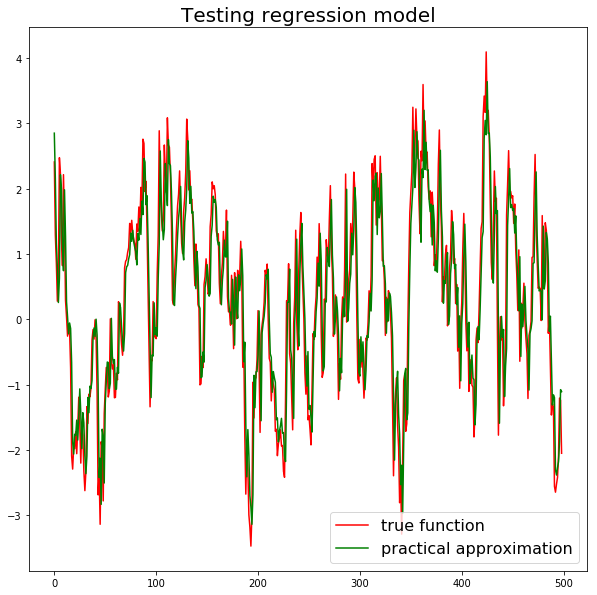

In [27]:
cur_lag = 1
N_pts = 500
plt.figure(figsize=(10, 10))
plt.title("Testing regression model",fontsize=20)
plt.plot(X_train[0,cur_lag:N_pts],color='r',label='true function')
plt.plot(P.polynomial.polyval(X_train[0,:N_pts-cur_lag],coefs_poly[cur_lag,:]),color='g',label = 'practical approximation')
#plt.plot(P.polynomial.polyval(X_train[0,:N_pts-cur_lag],coefs_poly_theor[cur_lag,:]),color='b',label = 'theoretical approximation')
plt.legend(loc = 'lower right',fontsize = 16)
plt.show()

In [28]:
sp.special.factorial2(21, exact=False)
moments_stand_norm = np.zeros(2*max_deg+1,dtype = float)
moments_stand_norm[0] = 1.0
moments_stand_norm[1] = 0.0
for i in range(len(moments_stand_norm)-2):
    moments_stand_norm[i+2] = sp.special.factorial2(i+1, exact=False)
#eliminate odd
moments_stand_norm[1::2] = 0
print(moments_stand_norm)

[1. 0. 1. 0. 3.]


In [29]:
N_burn = 10000
N_test = 2000 #size of test part
N_min = 1 #minimal number of observations to compute \pi_N
gamma = 0.2
X_test = np.zeros(N_test,dtype = float)
Noise = np.zeros_like(X_test)
N_traj = 10

test_stat_vanilla = np.zeros((N_traj,N_test),dtype = float)
test_stat_vr = np.zeros((N_traj,N_test),dtype = float)

In [30]:
for ind in range(N_traj):
    np.random.seed(1453 + ind)
    x0 = np.random.randn()
    x_cur = x0
    #burn-in
    for i in range(N_burn):
        x_cur = x_cur - gamma*f_grad(x_cur) + np.sqrt(2*gamma)*np.random.randn()
    #training sample
    #x_cur = X_last
    for i in range(N_test):
        Noise[i] = np.random.randn()
        x_cur = x_cur - gamma*f_grad(x_cur) + np.sqrt(2*gamma)*Noise[i]
        X_test[i] = x_cur
    #compute polynomials at Z_l
    poly_vals = np.zeros((max_deg+1,N_test),dtype = float)
    for k in range(max_deg+1):
        c = np.zeros(max_deg+1)
        c[k] = 1
        poly_vals[k,:] = P.hermite_e.hermeval(Noise,c)/np.sqrt(sp.special.factorial(k))
    f_vals_vanilla = set_func(X_test)
    cvfs = np.zeros_like(f_vals_vanilla)
    for i in range(1,len(cvfs)):
        #start computing a_{p-l} coefficients
        num_poly = min(lag,i)
        a_vals = np.zeros((num_poly,max_deg+1),dtype = float)
        for npol in range(num_poly):#for a fixed lag Q function
            #compute \hat{a} with fixed lag
            x = X_test[i-1-npol]#should be -2 here?
            a_cur = np.zeros(max_deg+1,dtype=float)
            for m in range(len(coefs_poly[0])):
                poly_vspom = np.zeros(max_deg+1,dtype=float)
                for u in range(m+1):
                    poly_vspom[u] = ((x-gamma*f_grad(x))**(m-u))*((np.sqrt(2*gamma))**u)*sp.special.binom(m,u)
                #print(poly_vspom)
                a_cur = P.polynomial.polyadd(a_cur,coefs_poly[npol,m]*poly_vspom)
            #print("a_cur")
            #print(a_cur)
            for k in range(1,max_deg+1):
                c = np.zeros(max_deg+1)
                c[k] = 1
                herm_coef = P.hermite_e.herme2poly(c)
                #normalize now
                herm_coef = herm_coef / np.sqrt(sp.special.factorial(k))
                integr_coefs = P.polynomial.polymul(herm_coef,a_cur)
                #Note that a_vals are stored in reversed order
                a_vals[-(npol+1),k] = np.dot(integr_coefs,moments_stand_norm[:len(integr_coefs)])
            #OK, now I have coefficients of the polynomial, and I need to integrate it w.r.t. Gaussian measure
        #print(a_vals.shape)
        #print(a_vals)
        cvfs[i] = np.sum(a_vals*(poly_vals[:,i-num_poly+1:i+1].T))
        #cvfs[i] = np.sum(np.mean(a_vals,axis = 0))
        if (i%100 == 0):
            print("100 observations proceeded")
        #save results
        test_stat_vanilla[ind,i] = np.mean(f_vals_vanilla[1:(i+1)])
        test_stat_vr[ind,i] = test_stat_vanilla[ind,i] - np.sum(cvfs[:i])/i

100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
100 observations proceeded
1

In [31]:
print(test_stat_vanilla[1,N_min:N_min+100])
print(test_stat_vr[1,N_min:N_min+100])
print(test_stat_vanilla[1,-1])
print(test_stat_vr[1,-1])

[ 0.54306916  0.31581812  0.14630489 -0.29955209 -0.72996497 -1.07892359
 -1.3415739  -1.46096445 -1.47012519 -1.54419619 -1.61537751 -1.66544396
 -1.71920923 -1.67065079 -1.52871376 -1.37287622 -1.31591564 -1.29053595
 -1.27155997 -1.21123772 -1.23781023 -1.29491857 -1.37300834 -1.43825552
 -1.4964546  -1.53205277 -1.49798902 -1.46895333 -1.43444428 -1.38713955
 -1.36087251 -1.34257134 -1.3606262  -1.34303804 -1.34299277 -1.32587903
 -1.31421774 -1.298335   -1.27801574 -1.2802619  -1.27512739 -1.26076758
 -1.25141545 -1.26807698 -1.28997029 -1.3089092  -1.34068635 -1.37358274
 -1.41524094 -1.43127169 -1.44647486 -1.45188893 -1.45942671 -1.45351068
 -1.42991321 -1.38343171 -1.33397372 -1.2798333  -1.23921603 -1.199446
 -1.15280245 -1.09538888 -1.04087175 -1.00566347 -0.98167234 -0.95448862
 -0.94313451 -0.92360552 -0.8931154  -0.87772346 -0.86773044 -0.84682031
 -0.81748397 -0.78567755 -0.74159286 -0.70810945 -0.67488173 -0.65021981
 -0.62795463 -0.6261288  -0.63554311 -0.64204165 -0.6

In [32]:
vars_vanilla = np.var(test_stat_vanilla,axis = 0)
vars_adj = np.var(test_stat_vr,axis = 0)
print(vars_vanilla[N_min:N_min+10])
print(vars_adj[N_min:N_min+10])
print(np.mean(vars_adj[N_min:]/vars_vanilla[N_min:]))

[2.64454983 2.48827938 2.28768178 2.17479818 2.32951868 2.1624117
 2.19431109 2.23181171 2.21715404 2.08637646]
[2.64454983 1.70404895 1.27215019 1.03016963 1.06625299 0.76721556
 0.74191023 0.6891382  0.60197723 0.49293512]
0.11883453822103263


In [33]:
print(np.mean(vars_adj[-10:]/vars_vanilla[-10:]))

0.10053953334694639
